In [1]:
#Importing required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Creating train and test data sets
train_data = MNIST(root='./data',
                  train=True,
                  download=True,
                  transform=transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize(mean=(0.5), std=(0.5))
                      ])
                   )

test_data = MNIST(root='./data',
                 train=False,
                 download=True,
                 transform=ToTensor())


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
# Creating test and train data loaders
train_loader = DataLoader(dataset=train_data, batch_size=128, num_workers=2, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=128, num_workers=1)

In [4]:
len(train_data)
# Checking length of training data

60000

In [5]:
images, label = next(iter(train_loader))
images.shape, label.shape
# Checking shapes of batch input and labels

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

tensor(4)

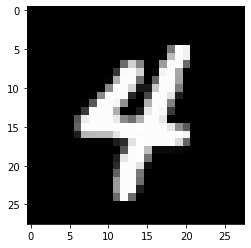

In [6]:
plt.imshow(images[0].squeeze(), cmap='gray')
label[0]
#Displaying number represented by specific image

Class for MNIST prediction. This is pretty simple dataset. We dont need convolutions here to accomplish the purpose here. We split the task in two parts. First we will train MNIST . And then use another class to combine MNIST prediction and random number.


In [7]:
class MNISTpred(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(nn.Linear(784,128, bias=False),
                                  nn.ReLU(inplace=True),
                                  nn.Dropout(0.3),
                                  nn.Linear(128,32, bias=False),
                                  nn.ReLU(inplace=True),
                                  nn.Dropout(0.3),
                                  nn.Linear(32,10)
                                  )
            
            
                 
        
    def forward(self, x):
      x = x.reshape(-1,784)
      x = self.fc(x)
      return x

In [8]:
model_mnist = MNISTpred().to('cuda')
# Instantiating MNIST prediction model and sending it to GPU

In [9]:
lr = 0.002
opt_mnist = Adam(model_mnist.parameters(), lr)
# instantiating optimizer with learning rate. We use Adam optimizer here which is best of the optimizers used in training neural networks

In [10]:
# We will train only for 4 epochs as we cross 90% accuracy in just 4 epochs. Higher accuracy is not required in this assignment.
num_epochs = 4

total_loss = 0
total_correct = 0
for epochs in range(1, num_epochs+1): ## Looping through epochs
  total_loss = 0
  total_correct = 0
  for batch, labels in train_loader: ## Looping through train loader, extracting batches of data
    batch = batch.to('cuda')  ## Sending batch data to GPU
    labels = labels.to('cuda') ## Sending labels data GPU
    pred = model_mnist(batch) ## Getting predictions from model
# We will use cross_entropy here as we have 10 outputs here. It will use softmax internally and then calculate loss. We will be summing up the loss for each 
# datapoint in batch and then sum it up. Later we will divide the sum of losses of all datapoints by dataset length to get average loss per datapoint. This should
# decrease as training progresses.
    loss = F.cross_entropy(pred, labels, reduction='sum') # Sum of losses for all datapoints in current batch
    opt_mnist.zero_grad() # Zeroing out the gradients
    loss.backward() ## Calculating and updating the gradients
    opt_mnist.step() ## Adjusting weights and biases as per gradients calculated in step above
    total_loss = total_loss + loss.item() # Total loss in this epoch till this point of time
    correct = torch.argmax(pred, dim=1).eq(labels).sum().item() # How many datapoints were accurately predicted in this batch
    total_correct = total_correct + correct # How many datapoints have been correctly predicted in this epoch till this point of time
  print(f'Epoch : {epochs} , Average Loss per datapoint : {total_loss/len(train_data)}, Correct Prediction : {total_correct}')

Epoch : 1 , Average Loss per datapoint : 0.6568013999621073, Correct Prediction : 47666
Epoch : 2 , Average Loss per datapoint : 0.3729534731864929, Correct Prediction : 53435
Epoch : 3 , Average Loss per datapoint : 0.3277930415153503, Correct Prediction : 54291
Epoch : 4 , Average Loss per datapoint : 0.29863061226209003, Correct Prediction : 54832


In [11]:
image, label = next(iter(test_loader))

In [12]:
image[2].shape, label[2]

(torch.Size([1, 28, 28]), tensor(1))

In [13]:
model_mnist.eval()
test_pred = model_mnist(image[2].to('cuda'))
torch.argmax(test_pred, dim=1).eq(label[2])
# Checking on evaluation of test data before actually inputting into class that will combine mnist output and random number

tensor([True], device='cuda:0')

In [14]:
torch.argmax(test_pred, dim=1).item()

1

In [15]:
np.random.randint(10)

3

In [16]:
# Class to sum the predicted label of MNIST dataset and random number. 
class mnist_sum_rand(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x, r):
    model_mnist.eval()
    test_pred = model_mnist(x.to('cuda')) # Inputs single image into mnist prediction model
    print("Predicted output on MNIST test data is  ", torch.argmax(test_pred, dim=1).item()) # Getting predicted output of mnist image inputted above
    print("Random number inputted is ", r)
    result = torch.argmax(test_pred, dim=1).item() 
    out = result + r # Summing up mnist output and random number
    print("sum of mnist prediction and random number is ", out)
    return  result, out # Sending mnist prediction and sum of mnist prediction and random number as return value

In [17]:
model = mnist_sum_rand().to('cuda') # Instantiating and Sending model to GPU

In [18]:
mnist_result, sm = model(image[2], np.random.randint(10)) # Calling the model to predict mnist label and sum it up with random number
mnist_result, sm

Predicted output on MNIST test data is   1
Random number inputted is  2
sum of mnist prediction and random number is  3


(1, 3)

In [19]:
sm = model(image[5], np.random.randint(10))
sm, label[5].item()

Predicted output on MNIST test data is   1
Random number inputted is  3
sum of mnist prediction and random number is  4


((1, 4), 1)